# 使用python编写CUSBoost
## 这里仅处理二分类的问题，大致思路如下：
### 1.对多数类进行K个簇的聚类，随机的挑选50%(可自选)的数据和少数类合并在一起
### 2.使用adaboost的方法训练合并后的数据
### 3.多次循环步骤1和2
## 算法权重更新的策略
### 一开始初始化每一个数据的权重为 $\frac{1}{d}$（d为所有训练样本的个数）
### 计算模型$M_i$的错误率，使用错分类数据的权重和来表示错误率 $$ error(M_i) = sum_{i=1}^{d}{w_i*err(x_i)} $$
这里，$err(x_i)$表示如果$x_i$被正确分类，$err(x_i)=0$;反之$err(x_i)=1$ <br />
如果$error(M_i)>=0.5$，抛弃这个模型并重新训练
### 如果$x_i$被正确分类，它的权重将乘以误差（$\frac{error(M_i)}{1-error(M_i)}$）,即$$w_i=w_i\frac{error(M_i)}{1-error(M_i)}$$
### 为了标准化(normalise)权重，我们让每一个权重乘以$\frac{sum_{i=1}^{d}{w^{old}_i}}{sum_{i=1}^{d}{w^{new}_i}}$

## 最终会得到多分类器和弱分类器的权值
### 预测结果的计算为：$y_{pro}=\frac{sum_{i=1}^{classifier\_num}{w_i*y\_pred_i}}{sum_{i=1}^{classifier\_num}w_i}$
其中，$w_i表示分类器的权值,y\_pred_i表示第i个分类器的结果$

In [1]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
import random
import math

%matplotlib inline


In [2]:
data = pd.read_csv("../dataset/1.pima.csv")

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [4]:
print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [5]:
print(data.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027465CA42E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000027466025E10>]], dtype=object)

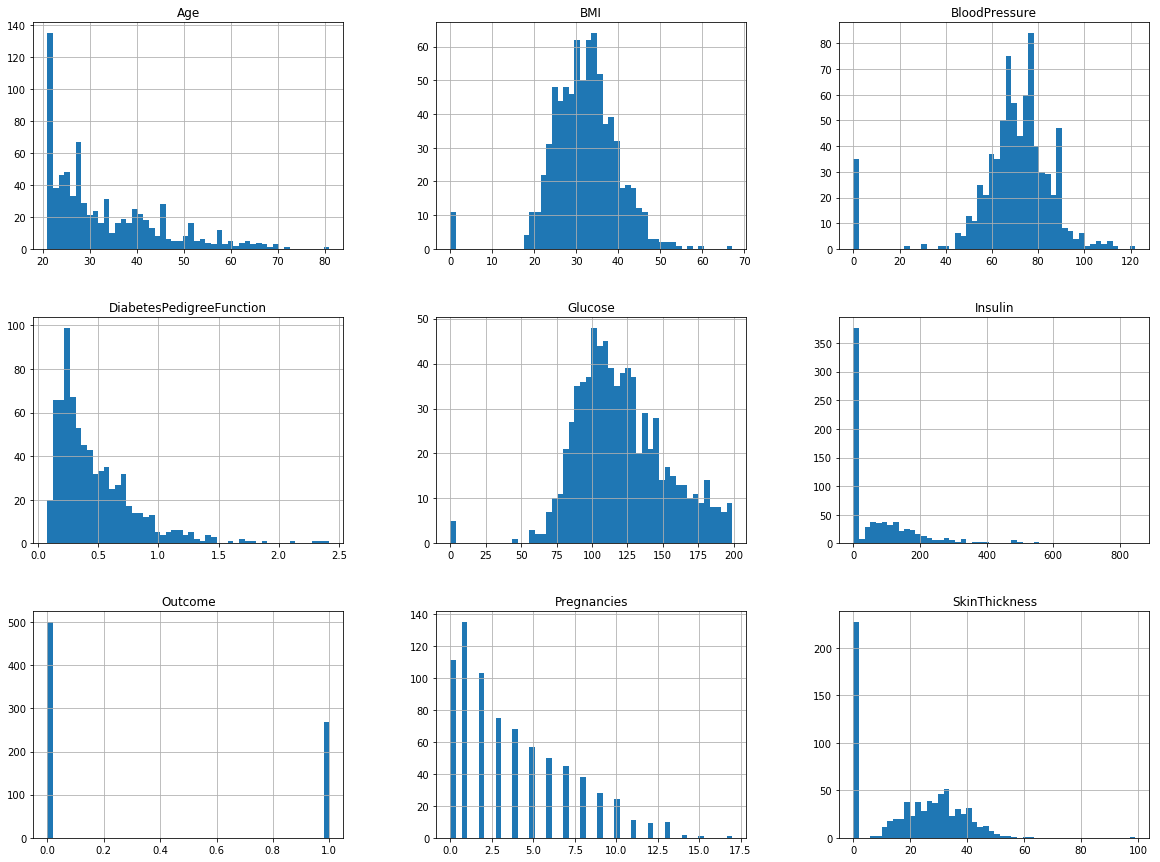

In [6]:
data.hist(bins=50, figsize=(20,15))

In [7]:
#保证运行该notebook的输出都一致
np.random.seed(0)

In [8]:
#标签与源数据集分开
y = data["Outcome"]
X = data.drop("Outcome",axis=1)

In [9]:
#分割训练集和测试集 
x_train,x_test,y_train,y_test = train_test_split(X,y)

print("X_train：%s"%str(x_train.shape))
print("y_train：%s"%str(y_train.shape))
print("x_test：%s"%str(x_test.shape))
print("y_test：%s"%str(y_test.shape))

X_train：(576, 8)
y_train：(576,)
x_test：(192, 8)
y_test：(192,)


(array([ 370.,    0.,    0.,    0.,  206.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 5 Patch objects>)

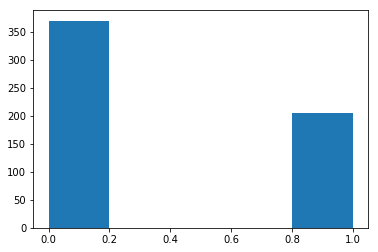

In [10]:
#train_data_with_labels = pd.concat([x_train,y_train],axis=1)
plt.hist(y_train,bins=5)

In [11]:
#sampling method
#Cluster UnderSampling + Adaboost
def CUSBoost(data,iteration_num,K,rate):
    '''
    data：不平衡的数据集,一条数据集一行,ndarray的格式,假设标签在最后一行，0表示多数样本，1表示少数样本
    iteration_num：迭代次数，迭代多少次就有多少个弱分类器
    K：使用聚类方法将多数类聚成K个簇
    rate：从每个簇中抽取多少的数据，rate=0.5，抽取50%的数据
    
    return：弱分类器和弱分类器的权重
    '''
    rows,columns = data.shape
    #计算权重
    weights = np.array([1/rows]*rows)
    #初始化弱分类器模型和弱分类器的权重
    weakClassModel = []
    weakClassWeights = []
    #分开少数类和多数类
    minor_data = data[data[:,-1] == 1]
    major_data = data[data[:,-1] == 0]
    #少数类和多数类的权重
    minor_weights = weights[data[:,-1] == 1]
    major_weights = weights[data[:,-1] == 0]
    #删除多数类的类标
    major_data = np.delete(major_data,-1,axis=1)
    #使用聚类的方法将多数类进行聚类
    clusters = KMeans(n_clusters=K, random_state=0).fit(X)
    #进行迭代训练基分类器
    i=0
    while i <iteration_num:
        #随机从每个簇抽取的多数类的角标
        random_major_index = []
        
        classes = clusters.predict(major_data)#每个多数类所属的类别
        cluster_num = len(classes) #多数类的数量
        myArr = np.array(range(cluster_num))
        #从每个簇中随机下采样簇总数*rate个
        for j in range(K):
            #第j个簇中多数类的角标
            cluster_index = list(myArr[classes==j])
            rand_index = random.sample(cluster_index,int(len(cluster_index)*rate))
            random_major_index.extend(rand_index)
        #将聚类后随机从每个簇选择出的数据角标从小到大排个序
        random_major_index.sort()
        major_num = len(random_major_index)
        minor_num = len(minor_data)
        print("多数类："+str(major_num))
        print("少数类："+str(minor_num))
        print("不平衡程度(少数类/多数类)："+str(minor_num/major_num))
        #和少数类数据结合在一起进行训练,拼接后前major_num个为多数类
        train_data = np.r_[np.c_[major_data[random_major_index],np.zeros(len(random_major_index))],minor_data]
        train_data_Arr = np.array(range(len(train_data)))
        #默认采用基尼指数作为特征选择标准
        clf = DecisionTreeClassifier(criterion="entropy",max_depth=1)
        clf = clf.fit(train_data[:,0:-1], train_data[:,-1])
        y_pred = clf.predict(train_data[:,0:-1])
        
        accuracy = (y_pred == train_data[:,-1]).flatten().astype("int").sum()/len(train_data)
        print("准确率："+str(accuracy))
        
        #计算error损失
        #不正确和正确预测的角标
        error_index = train_data_Arr[y_pred != train_data[:,-1]]
        major_error_index = np.array(random_major_index)[[x for x in error_index if x < major_num]]
        major_correct_index = list(set(random_major_index)-set(major_error_index))#多数类正确分类的角标
        minor_error_index = [x-major_num for x in error_index if x >= major_num]
        minor_correct_index = list(set(range(len(minor_data)))-set(minor_error_index))
        
#         print(major_error_index)
#         print(minor_error_index)
        
        #计算error(clf)
        major_error = major_weights[major_error_index].flatten()
        minor_error = minor_weights[minor_error_index].flatten()
        error = minor_error.sum()+major_error.sum()
        print("模型的error："+str(error))
        if error < 0.5:
            #记录更新前的权重和
            old_weights_sum = major_weights.sum() + minor_weights.sum()
            #更新每一个在此次训练中出现的样本权重
            major_weights[major_correct_index] = major_weights[major_correct_index]*(error/(1-error))
            minor_weights[minor_correct_index] = minor_weights[minor_correct_index]*(error/(1-error))
            #记录更新后的权重
            new_weights_sum = major_weights.sum() + minor_weights.sum()

#             print(old_weights_sum,new_weights_sum)
            
            #标准化权值
            normalise_num = old_weights_sum/new_weights_sum
            major_weights = major_weights*normalise_num
            minor_weights = minor_weights*normalise_num
            
            #添加基分类器和分类器权重
            weakClassModel.append(clf)
            weakClassWeights.append(math.log((1-error)/error))
            
            i+=1
    
    return weakClassModel,weakClassWeights
    
    

In [12]:
train_data = np.array(pd.concat([x_train,y_train],axis=1))
CUSBoost(train_data,500,5,0.5)

多数类：184
少数类：206
不平衡程度(少数类/多数类)：1.1195652173913044
准确率：0.728205128205
模型的error：0.184027777778
多数类：184
少数类：206
不平衡程度(少数类/多数类)：1.1195652173913044
准确率：0.679487179487
模型的error：0.227089109858
多数类：184
少数类：206
不平衡程度(少数类/多数类)：1.1195652173913044
准确率：0.728205128205
模型的error：0.340644394275
多数类：184
少数类：206
不平衡程度(少数类/多数类)：1.1195652173913044
准确率：0.689743589744
模型的error：0.264879852922
多数类：184
少数类：206
不平衡程度(少数类/多数类)：1.1195652173913044
准确率：0.715384615385
模型的error：0.332083666503
多数类：184
少数类：206
不平衡程度(少数类/多数类)：1.1195652173913044
准确率：0.676923076923
模型的error：0.252393543852
多数类：184
少数类：206
不平衡程度(少数类/多数类)：1.1195652173913044
准确率：0.728205128205
模型的error：0.39403780098
多数类：184
少数类：206
不平衡程度(少数类/多数类)：1.1195652173913044
准确率：0.687179487179
模型的error：0.319495682005
多数类：184
少数类：206
不平衡程度(少数类/多数类)：1.1195652173913044
准确率：0.728205128205
模型的error：0.503076833212
多数类：184
少数类：206
不平衡程度(少数类/多数类)：1.1195652173913044
准确率：0.728205128205
模型的error：0.445558606184
多数类：184
少数类：206
不平衡程度(少数类/多数类)：1.1195652173913044
准确率：0.715384615385
模型

([DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  DecisionTreeClassifier(class_